In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Imports

In [ ]:
from numpy import load
from numpy import zeros
from numpy import ones
from numpy.random import randint
from keras.optimizers import Adam
from keras.initializers import RandomNormal
from keras.models import Model
from keras.models import Input
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Activation
from keras.layers import Concatenate
from keras.layers import Dropout
from keras.layers import BatchNormalization
from keras.layers import LeakyReLU
from matplotlib import pyplot
from numpy import expand_dims
# load, split and scale the maps dataset ready for training
from os import listdir
from numpy import asarray
from numpy import vstack
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import load_img
from numpy import savez_compressed
import PIL
import numpy as np
import matplotlib.pyplot as plt
# Edifice detection module
import cv2
from google.colab.patches import cv2_imshow
# calculate inception score for cifar-10 in Keras
from math import floor
from numpy import ones
from numpy import expand_dims
from numpy import log
from numpy import mean
from numpy import std
from numpy import exp
from numpy.random import shuffle
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input
from keras.datasets import cifar10
from skimage.transform import resize
from numpy import asarray

### Preprocessing

In [ ]:
# load all images in a directory into memory
def load_images(path, size=(256,512)):
	src_list, tar_list = list(), list()
	# enumerate filenames in directory, assume all are images
	for filename in listdir(path):
		# load and resize the image
		pixels = load_img(path + filename, target_size=size)
		# convert to numpy array
		pixels = img_to_array(pixels)
		# split into satellite and map
		sat_img, map_img = pixels[:, :256], pixels[:, 256:]
		src_list.append(sat_img)
		tar_list.append(map_img)
	return [asarray(src_list), asarray(tar_list)]

In [ ]:
def compress_images(path, filename): 
    [src_images, tar_images] = load_images(path)
    print('Loaded: ', src_images.shape, tar_images.shape)
    savez_compressed(filename, src_images, tar_images)
    print('Saved dataset: ', filename)

In [ ]:
compress_images('/content/drive/MyDrive/CIP_Project/maps/train/', 'maps_256.npz')

In [ ]:
# load and prepare training images
def load_real_samples(filename):
	# load compressed arrays
	data = load(filename)
	# unpack arrays
	X1, X2 = data['arr_0'], data['arr_1']
	# scale from [0,255] to [-1,1]
	X1 = (X1 - 127.5) / 127.5
	X2 = (X2 - 127.5) / 127.5
	return [X1, X2]

In [ ]:
# load image data
dataset = load_real_samples('/content/drive/MyDrive/CIP_Project/maps_256.npz')
print('Loaded', dataset[0].shape, dataset[1].shape)
image_shape = dataset[0].shape[1:]
print(image_shape)

Loaded (1096, 256, 256, 3) (1096, 256, 256, 3)
(256, 256, 3)


### Generator Module

In [ ]:
# define an encoder block
def define_encoder_block(layer_in, n_filters, batchnorm=True):
    # weight initialization
    init = RandomNormal(stddev=0.02)
    # add downsampling layer
    g = Conv2D(n_filters, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(layer_in)
    # conditionally add batch normalization
    if batchnorm:
        g = BatchNormalization()(g, training=True)
    # leaky relu activation
    g = LeakyReLU(alpha=0.2)(g)
    #print("Input ",layer_in.shape," Output ",g.shape)
    return g

In [ ]:
# define a decoder block
def decoder_block(layer_in, skip_in, n_filters, dropout=True):
    # weight initialization
    init = RandomNormal(stddev=0.02)
    # add upsampling layer
    #print("Before Conv2dTranspose Shape = ",layer_in.shape)
    g = Conv2DTranspose(n_filters, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(layer_in)
    #print("After Conv2dTranspose Shape = ",g.shape)
    # add batch normalization
    g = BatchNormalization()(g, training=True)
    # conditionally add dropout
    #print("Before Dropout ",g.shape)
    if dropout:
        g = Dropout(0.5)(g, training=True)
        #print("After Dropout ",g.shape)
    # merge with skip connection
    #print("G.shape =  ",g.shape,"Skip-in.shape = ",skip_in.shape)
    g = Concatenate()([g, skip_in])
    #print("Concatenated Shape = ",g.shape)
    # relu activation
    g = Activation('relu')(g)
    #print("Input ",layer_in.shape," Output ",g.shape)
    return g

In [ ]:
# define the standalone generator model
def define_generator(image_shape=(256,256,3)):
    # weight initialization
    init = RandomNormal(stddev=0.02)
    # image input
    in_image = Input(shape=image_shape)
    # encoder model
    e1 = define_encoder_block(in_image, 64, batchnorm=False)
    e2 = define_encoder_block(e1, 128)
    e3 = define_encoder_block(e2, 256)
    e4 = define_encoder_block(e3, 512)
    e5 = define_encoder_block(e4, 512)
    e6 = define_encoder_block(e5, 512)
    e7 = define_encoder_block(e6, 512)
    # bottleneck, no batch norm and relu
    b = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(e7)
    b = Activation('relu')(b)
    # decoder model
    d1 = decoder_block(b, e7, 512)
    d2 = decoder_block(d1, e6, 512)
    d3 = decoder_block(d2, e5, 512)
    d4 = decoder_block(d3, e4, 512, dropout=False)
    d5 = decoder_block(d4, e3, 256, dropout=False)
    d6 = decoder_block(d5, e2, 128, dropout=False)
    d7 = decoder_block(d6, e1, 64, dropout=False)
    # output
    #print("###Before Conv2dTranspose Shape = ",d7.shape)
    g = Conv2DTranspose(3, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d7)
    #print("###After Conv2dTranspose Shape = ",g.shape)
    out_image = Activation('tanh')(g)
    # define model
    model = Model(in_image, out_image)
    return model

In [ ]:
g_model = define_generator(image_shape)

In [ ]:
print(g_model.input_shape)
print(g_model.output_shape)

(None, 256, 256, 3)
(None, 256, 256, 3)


In [ ]:
g_model.summary()

Model: "model_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d_80 (Conv2D)              (None, 128, 128, 64) 3136        input_11[0][0]                   
__________________________________________________________________________________________________
leaky_re_lu_70 (LeakyReLU)      (None, 128, 128, 64) 0           conv2d_80[0][0]                  
__________________________________________________________________________________________________
conv2d_81 (Conv2D)              (None, 64, 64, 128)  131200      leaky_re_lu_70[0][0]             
____________________________________________________________________________________________

### Discriminator Module

In [ ]:
# define the discriminator model
def define_discriminator(image_shape):
    # weight initialization
    init = RandomNormal(stddev=0.02)
    # source image input
    in_src_image = Input(shape=image_shape)
    #print("src =",in_src_image.shape)
    # target image input
    in_target_image = Input(shape=image_shape)
    #print("tar =",in_target_image.shape)
    # concatenate images channel-wise
    merged = Concatenate()([in_src_image, in_target_image])
    #print("merged =",merged.shape)
    # C64
    
    d = Conv2D(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(merged)
    d = LeakyReLU(alpha=0.2)(d)
    
    # C128
    
    d = Conv2D(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
    d = BatchNormalization()(d)
    d = LeakyReLU(alpha=0.2)(d)
    
    # C256
    
    d = Conv2D(256, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
    d = BatchNormalization()(d)
    d = LeakyReLU(alpha=0.2)(d)
    
    # C512
    
    d = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
    d = BatchNormalization()(d)
    d = LeakyReLU(alpha=0.2)(d)
    
    # second last output layer
    
    d = Conv2D(512, (4,4),strides=(1,1), padding='same', kernel_initializer=init)(d)
    d = BatchNormalization()(d)
    d = LeakyReLU(alpha=0.2)(d)
    
    # patch output
    #print("initial d =",d.shape)
    d = Conv2D(1, (4,4), padding='same', kernel_initializer=init)(d)
    #print("final d =",d.shape)
    patch_out = Activation('sigmoid')(d)
    # define model
    model = Model([in_src_image, in_target_image], patch_out)
    # compile model
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, loss_weights=[0.5])
    return model


In [ ]:
d_model = define_discriminator(image_shape)

In [ ]:
print(d_model.input_shape)
print(d_model.output_shape)

[(None, 256, 256, 3), (None, 256, 256, 3)]
(None, 16, 16, 1)


In [ ]:
d_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
concatenate_7 (Concatenate)     (None, 256, 256, 6)  0           input_2[0][0]                    
                                                                 input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_8 (Conv2D)               (None, 128, 128, 64) 6208        concatenate_7[0][0]        

In [ ]:
d_model.layers

### GAN Definition

In [ ]:
# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model, image_shape):
    # make weights in the discriminator not trainable
    for layer in d_model.layers:
        #print(layer.trainable," ",layer)
        if not isinstance(layer, BatchNormalization):
            layer.trainable = False
    # define the source image
    in_src = Input(shape=image_shape)
    # connect the source image to the generator input
    gen_out = g_model(in_src)
    #print("Output of generator",gen_out.shape)
    # connect the source input and generator output to the discriminator input
    dis_out = d_model([in_src, gen_out])
    #print("Output of discriminator",dis_out.shape)
    # src image as input, generated image and classification output
    model = Model(in_src, [dis_out, gen_out])
    # compile model
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss=['binary_crossentropy', 'mae'], optimizer=opt, loss_weights=[1,100])
    return model

In [ ]:
gan_model = define_gan(g_model, d_model, image_shape)

In [ ]:
print(gan_model.input_shape)
print(gan_model.output_shape)

(None, 256, 256, 3)
[(None, 16, 16, 1), (None, 256, 256, 3)]


In [ ]:
gan_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
model (Functional)              (None, 256, 256, 3)  54429315    input_4[0][0]                    
__________________________________________________________________________________________________
model_1 (Functional)            (None, 16, 16, 1)    6968257     input_4[0][0]                    
                                                                 model[0][0]                      
Total params: 61,397,572
Trainable params: 54,422,275
Non-trainable params: 6,975,297
__________________________________________________________________________________________________


### Training GAN  

In [ ]:
# select a batch of random samples, returns images and target
def generate_real_samples(dataset, n_samples, patch_shape):
	# unpack dataset
	trainA, trainB = dataset
	# choose random instances
  # ix is a list of 3 integer indices
	ix = randint(0, trainA.shape[0], n_samples)
	# retrieve selected images
	X1, X2 = trainA[ix], trainB[ix]
	# generate 'real' class labels (1)
	y = ones((n_samples, patch_shape, patch_shape, 1))
	return [X1, X2], y

In [ ]:
# generate a batch of images, returns images and targets
def generate_fake_samples(g_model, samples, patch_shape):
# generate fake instance
    X = g_model.predict(samples)
    #print(X.shape)
    # create 'fake' class labels (0)
    y = zeros((len(X), patch_shape, patch_shape, 1))
    return X, y

In [ ]:
# generate samples and save as a plot and save the model
def summarize_performance(step, g_model, d_model, dataset, n_samples=3):
	# select a sample of input images
	[X_realA, X_realB], _ = generate_real_samples(dataset, n_samples, 1)
	# generate a batch of fake samples
	X_fakeB, _ = generate_fake_samples(g_model, X_realA, 1)
	# scale all pixels from [-1,1] to [0,1]
	X_realA = (X_realA + 1) / 2.0
	X_realB = (X_realB + 1) / 2.0
	X_fakeB = (X_fakeB + 1) / 2.0
	# plot real source images
	for i in range(n_samples):
		pyplot.subplot(3, n_samples, 1 + i)
		pyplot.axis('off')
		pyplot.imshow(X_realA[i])
	# plot generated target image
	for i in range(n_samples):
		pyplot.subplot(3, n_samples, 1 + n_samples + i)
		pyplot.axis('off')
		pyplot.imshow(X_fakeB[i])
	# plot real target image
	for i in range(n_samples):
		pyplot.subplot(3, n_samples, 1 + n_samples*2 + i)
		pyplot.axis('off')
		pyplot.imshow(X_realB[i])
	# save plot to file
	filename1 = 'plot_%06d.png' % (step+1)
	pyplot.savefig(filename1)
	pyplot.close()
	# save the generator model
	filename2 = 'g_model_%06d' % (step+1)
	g_model.save(filename2)
#    filename3 = 'd_model_%06d.h5' % (step+1)
	filename3 = 'd_model_%06d' % (step+1)
	d_model.save(filename3)
	print('>Saved: %s and %s and %s' % (filename1, filename2, filename3))

In [ ]:
# train pix2pix models
def train(d_model, g_model, gan_model, dataset, n_epochs=200, n_batch=1):
    # determine the output square shape of the discriminator
    n_patch = d_model.output_shape[1]
    # unpack dataset
    trainA, trainB = dataset
    # calculate the number of batches per training epoch
    bat_per_epo = int(len(trainA) / n_batch)
    # calculate the number of training iterations
    n_steps = bat_per_epo * n_epochs
    # manually enumerate epochs
    for i in range(n_steps):
        # select a batch of real samples
        [X_realA, X_realB], y_real = generate_real_samples(dataset, n_batch, n_patch)
        # generate a batch of fake samples
        X_fakeB, y_fake = generate_fake_samples(g_model, X_realA, n_patch)
        # update discriminator for real samples
        d_loss1 = d_model.train_on_batch([X_realA, X_realB], y_real)
        # update discriminator for generated samples
        d_loss2 = d_model.train_on_batch([X_realA, X_fakeB], y_fake)
        # update the generator
        g_loss, _, _ = gan_model.train_on_batch(X_realA, [y_real, X_realB])
        # summarize performance
        print('>%d, d1[%.3f] d2[%.3f] g[%.3f]' % (i+1, d_loss1, d_loss2, g_loss))
        # summarize model performance
        if (i+1) % (bat_per_epo * 5) == 0:
            summarize_performance(i, g_model, d_model, dataset)

In [ ]:
train(d_model, g_model, gan_model, dataset)

### Edifice Detection Module

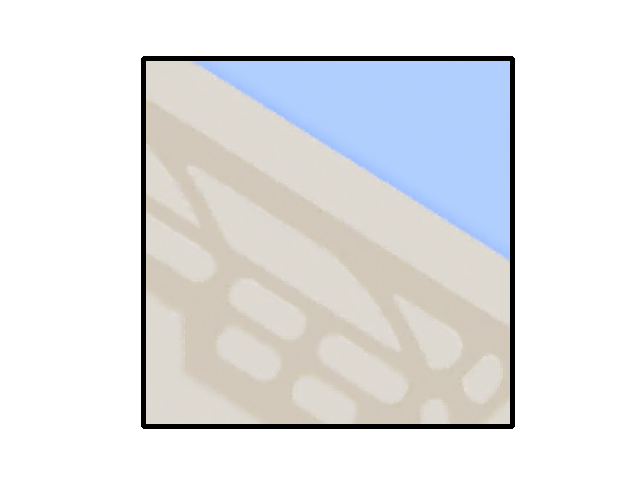

In [ ]:
img = cv2.imread("/content/Figure_4.png")
imgGry = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

ret , thresh = cv2.threshold(imgGry, 240 , 255, cv2.THRESH_BINARY_INV)    # cv2.CHAIN_APPROX_NONE == cv2.THRESH_BINARY_INV
contours , hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)

for contour in contours:
    approx = cv2.approxPolyDP(contour, 0.01* cv2.arcLength(contour, True), True)
    cv2.drawContours(img, [approx], 0, (0, 0, 0), 4)
    if len(approx) == 4 :
        x, y , w, h = cv2.boundingRect(approx)

cv2_imshow(img)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [ ]:
ret

240.0

In [ ]:
thresh.shape

(480, 640)

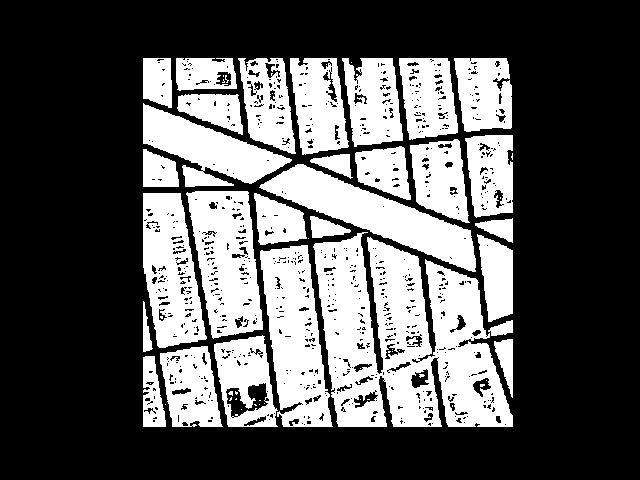

In [ ]:
cv2_imshow(thresh)

### Inception Score Calculation

In [ ]:
def scale_images(images, new_shape):
    images_list = list()
    for image in images:
        # resize with nearest neighbor interpolation
        new_image = resize(image, new_shape)
        # store
        images_list.append(new_image)
    return asarray(images_list)

In [ ]:
# assumes images have any shape and pixels in [0,255]
def calculate_inception_score(self,images, n_split=10, eps=1E-16):
    # load inception v3 model
    model = InceptionV3()
    # enumerate splits of images/predictions
    scores = list()
    n_part = floor(images.shape[0] / n_split)
    for i in range(n_split):
        # retrieve images
        ix_start, ix_end = i * n_part, (i+1) * n_part
        subset = images[ix_start:ix_end]
        # convert from uint8 to float32
        subset = subset.astype('float32')
        # scale images to the required size
        subset = scale_images(subset, (299,299,3))
        # pre-process images, scale to [-1,1]
        subset = preprocess_input(subset)
        # predict p(y|x)
        p_yx = model.predict(subset)
        # calculate p(y)
        p_y = expand_dims(p_yx.mean(axis=0), 0)
        # calculate KL divergence using log probabilities
        kl_d = p_yx * (log(p_yx + eps) - log(p_y + eps))
        # sum over classes
        sum_kl_d = kl_d.sum(axis=1)
        # average over images
        avg_kl_d = mean(sum_kl_d)
        # undo the log
        is_score = exp(avg_kl_d)
        # store
        scores.append(is_score)
    # average across images
    is_avg, is_std = mean(scores), std(scores)
    return is_avg, is_std

In [ ]:
[X1, X2] = load_real_samples('/content/drive/MyDrive/CIP_Project/maps_256.npz')
print('Loaded', X1.shape, X2.shape)
model = load_model('/content/drive/MyDrive/CIP_Project/g6.2/')
val_predicted = list()
i = 0
for image in X1:
  print(i)
  i = i + 1
  image = expand_dims(image,axis = 0)
  gen_image = model.predict(image)
  val_predicted.append(gen_image)
  
out = asarray(val_predicted)
out = np.transpose(out,(1,0,2,3,4))
out = out[0]

In [ ]:
images = out
shuffle(images)
print('loaded', images.shape)
# calculate inception score
is_avg, is_std = calculate_inception_score(images)
print('score', is_avg, is_std)